In [1]:
import pandas as pd
import regex as re
import numpy as np

from scipy import stats

import seaborn as sns
import matplotlib.pyplot as plt

from collections import Counter

import networkx as nx

%matplotlib inline

In [2]:
df = pd.read_pickle("model_data.pkl")
df = df[df['multi_label'].notnull()]  # filter all hypothetical proteins out of the data frame

df['multi_label_clean'] = df['multi_label'].apply(
    lambda x: list(set([re.split('(.)\[|\(', s)[0].strip() for s in x.split(';')])))

unique_df = df[['KO', 'multi_label_clean']].drop_duplicates(['KO'])

In [3]:
labels_to_keep = []
  
with open('labels2keep.txt', 'r') as file:
    for line in file:
        word = line.strip()
        l_word = (word).split(' [')
        labels_to_keep.append(l_word[0])    

# Function to filter the multi_label lists
def filter_list(lst):
    return [l for l in lst if l in labels_to_keep]

# Apply the filter_list function to the column
unique_df['multi_label_clean'] = unique_df['multi_label_clean'].apply(lambda x: filter_list(x))

# Drop rows with empty lists
unique_df = unique_df[unique_df['multi_label_clean'].astype(bool)]

print(unique_df)

# membrane traficking is out????

            KO                                  multi_label_clean
0       K07728                            [Transcription factors]
1       K00286                  [Arginine and proline metabolism]
2       K00053  [Pantothenate and CoA biosynthesis, Valine, le...
3       K02868         [Ribosome, Coronavirus disease - COVID-19]
4       K02987         [Ribosome, Coronavirus disease - COVID-19]
...        ...                                                ...
561661  K21794                         [Linoleic acid metabolism]
561801  K11567               [Chromosome and associated proteins]
562230  K21296                             [Secondary metabolism]
562232  K15183  [Transcription machinery, Protein phosphatases...
562863  K15416                 [Polyketide biosynthesis proteins]

[13942 rows x 2 columns]


In [4]:
functions_dict = {}
[functions_dict.update({func: (1 if func not in functions_dict else functions_dict[func] + 1)})
    for multi_lst in unique_df.multi_label_clean.tolist() for func in multi_lst]

functions_dict

{'Transcription factors': 633,
 'Arginine and proline metabolism': 101,
 'Pantothenate and CoA biosynthesis': 40,
 'Valine, leucine and isoleucine biosynthesis': 17,
 'Ribosome': 160,
 'Coronavirus disease - COVID-19': 125,
 'DNA repair and recombination proteins': 388,
 'Transporters': 1518,
 'Phenylalanine, tyrosine and tryptophan biosynthesis': 67,
 'Ribosome biogenesis': 313,
 'Pyrimidine metabolism': 100,
 'Alanine, aspartate and glutamate metabolism': 67,
 'Mismatch repair': 43,
 'Amino acid related enzymes': 100,
 'Enzymes with EC numbers': 1153,
 'Transfer RNA biogenesis': 239,
 'DNA replication proteins': 167,
 'Prokaryotic defense system': 164,
 'Cysteine and methionine metabolism': 112,
 'Chromosome and associated proteins': 773,
 'Methane metabolism': 187,
 'Streptomycin biosynthesis': 18,
 'Polyketide sugar unit biosynthesis': 44,
 'Acarbose and validamycin biosynthesis': 24,
 'Amino sugar and nucleotide sugar metabolism': 143,
 'Peptidases and inhibitors': 582,
 'Aminoacy

In [5]:
max(functions_dict.values())
# 1518 - Transporters

1518

In [6]:
relevant_functions = [key for key, val in functions_dict.items() if val != 1]

# 267 relevant functions 

In [7]:
def create_func_mat(relevant_functions):
    n = len(relevant_functions)

    # dictionary for translating label names to a serial number (matrix index)
    relevant_functions_dict = {relevant_functions[i]: i for i in range(n)}

    func_mat = np.zeros((n, n))

    for multi_lst in unique_df.multi_label_clean.tolist():
        for i in range(len(multi_lst)):
            for j in range(i, len(multi_lst)):
                try:
                    if i != j:
                        func_mat[relevant_functions_dict[multi_lst[i]], relevant_functions_dict[multi_lst[j]]] += 1
                        func_mat[relevant_functions_dict[multi_lst[j]], relevant_functions_dict[multi_lst[i]]] += 1
                    elif i == j:
                        func_mat[relevant_functions_dict[multi_lst[i]], relevant_functions_dict[multi_lst[j]]] += 1      
                except KeyError:
                    pass
                
    return(func_mat, relevant_functions_dict)

In [8]:
func_mat = create_func_mat(relevant_functions)[0] # cell i,j has the number of unique KO's that has the functions i and j together (i.e. in the same multi_label)
# function i refers to relevant_functions[i]

func_mat

array([[633.,   1.,   0., ...,   0.,   0.,   0.],
       [  1., 101.,   3., ...,   0.,   0.,   0.],
       [  0.,   3.,  40., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ...,   4.,   0.,   0.],
       [  0.,   0.,   0., ...,   0.,  11.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,   3.]])

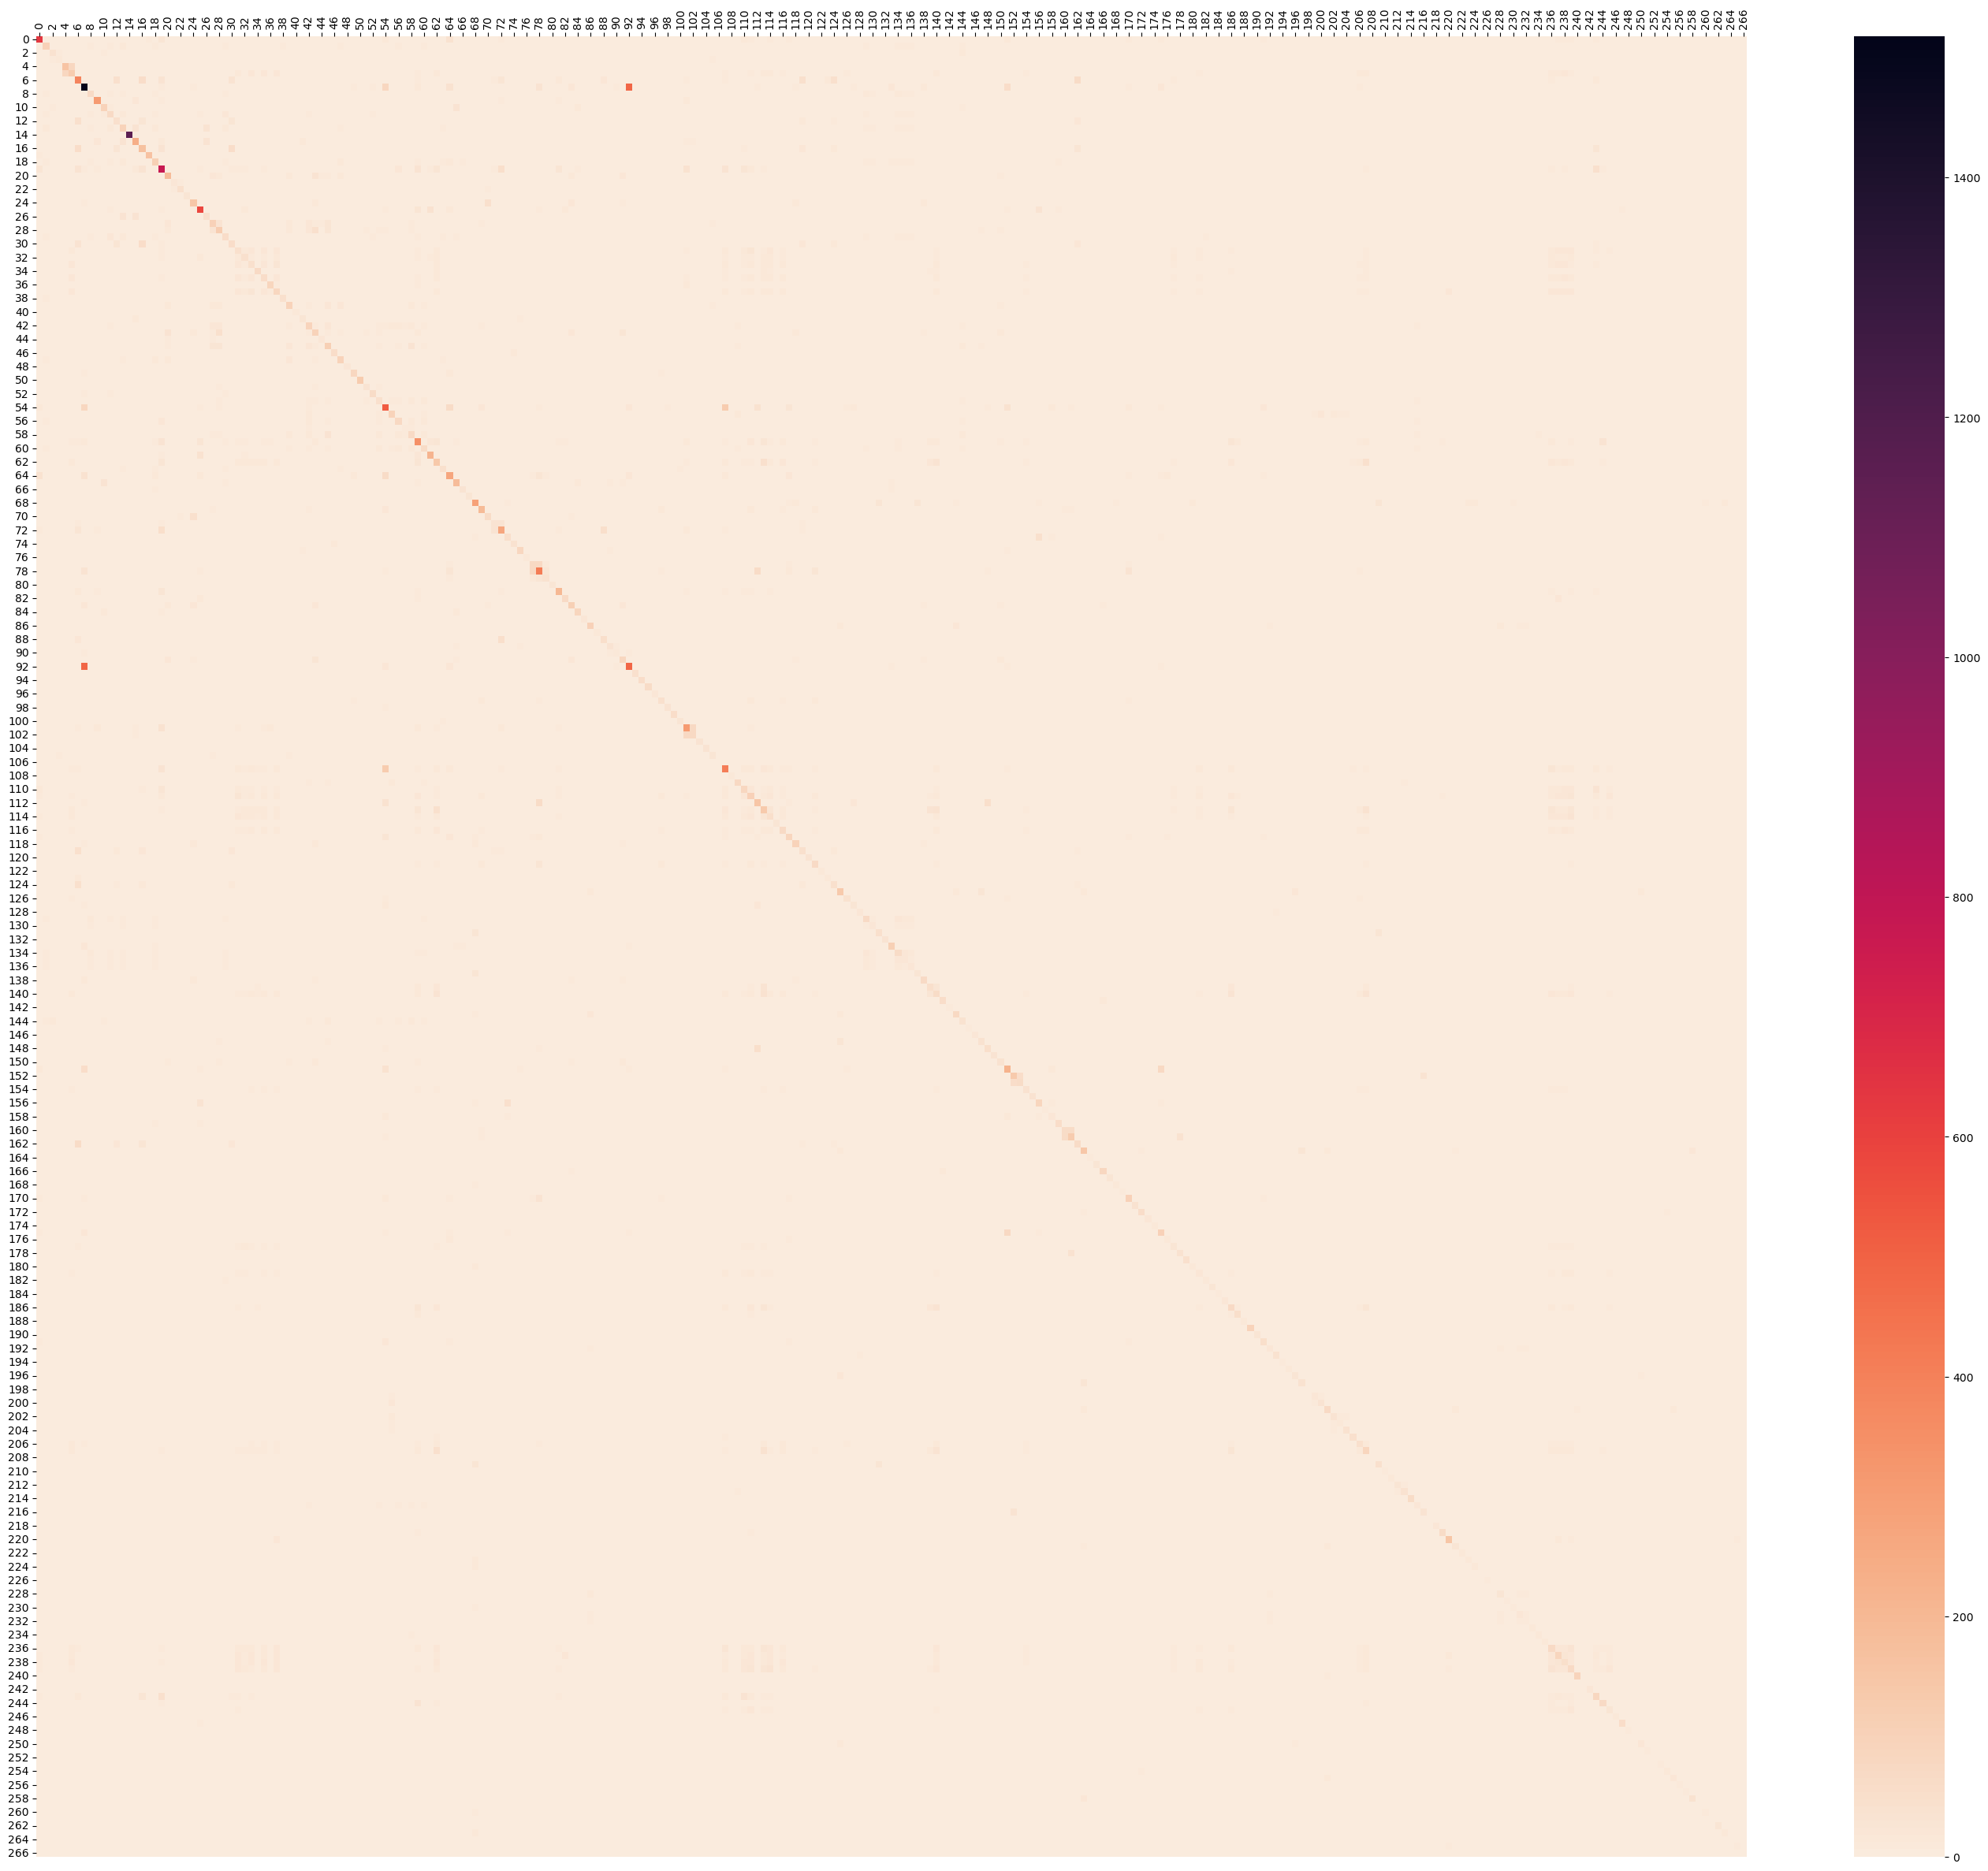

In [9]:
fig, ax = plt.subplots(figsize=(35, 30))

heatmap = sns.heatmap(func_mat, cmap = "rocket_r", ax=ax)

# Move the x-axis labels to the top
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, ha='center')
ax.xaxis.tick_top()


plt.show()

# heatmap isn't very usefull, most values are 0

In [10]:
# getting maximal pair value
mask = np.ones(func_mat.shape, dtype=bool)
np.fill_diagonal(mask, 0)
max_value = func_mat[mask].max()

max_value

487.0

In [11]:
# func_mat contains mostly zeros due to the large number of functions
mat_without_zeros = np.ma.masked_equal(func_mat, 0)

median = np.ma.median(mat_without_zeros) # finding the median value of func_mat ignoring zeros, 3.0
quan = np.quantile(func_mat, 0.99) # finding the 0.99 quantile including zeros, 11.0

# max value in func_mat - 487 'Transporters' and 'ABC transporters'

In [12]:
pairs = set()
n = len(func_mat)

for i in range(n):
    for j in range(i+1, n):
        if func_mat[i][j] > quan:
            pairs.add((relevant_functions[i], relevant_functions[j]))
            
# 219 pairs

In [13]:
pairs

{('Alanine, aspartate and glutamate metabolism', 'Arginine biosynthesis'),
 ('Amino acid related enzymes', 'Aminoacyl-tRNA biosynthesis'),
 ('Amino acid related enzymes', 'Cysteine and methionine metabolism'),
 ('Amino acid related enzymes', 'Transfer RNA biogenesis'),
 ('Amino sugar and nucleotide sugar metabolism',
  'Fructose and mannose metabolism'),
 ('Amino sugar and nucleotide sugar metabolism',
  'O-Antigen nucleotide sugar biosynthesis'),
 ('Antimicrobial resistance genes', 'Vancomycin resistance'),
 ('Antimicrobial resistance genes', 'beta-Lactam resistance'),
 ('Autophagy - yeast', 'Shigellosis'),
 ('Bacterial invasion of epithelial cells',
  'Pathogenic Escherichia coli infection'),
 ('Bacterial invasion of epithelial cells',
  'Regulation of actin cytoskeleton'),
 ('Bacterial invasion of epithelial cells', 'Yersinia infection'),
 ('Bacterial motility proteins', 'Bacterial chemotaxis'),
 ('Bacterial motility proteins', 'Flagellar assembly'),
 ('Bacterial secretion system', 

In [14]:
# trying to create a more useful mat and heatmap
average_num_of_appearances = np.mean(np.array(list(functions_dict.values())))
relevant_functions_avg = [key for key, val in functions_dict.items() if val > average_num_of_appearances]

# number of relevant functions reduced to 65

In [15]:
average_num_of_appearances

80.86245353159852

In [16]:
func_mat_2 = create_func_mat(relevant_functions_avg)[0]

func_mat_2

array([[633.,   1.,   0., ...,   0.,   6.,   0.],
       [  1., 101.,   0., ...,   0.,   0.,   0.],
       [  0.,   0., 160., ...,   0.,   0.,   0.],
       ...,
       [  0.,   0.,   0., ..., 153.,  17.,   0.],
       [  6.,   0.,   0., ...,  17.,  85.,   0.],
       [  0.,   0.,   0., ...,   0.,   0.,  93.]])

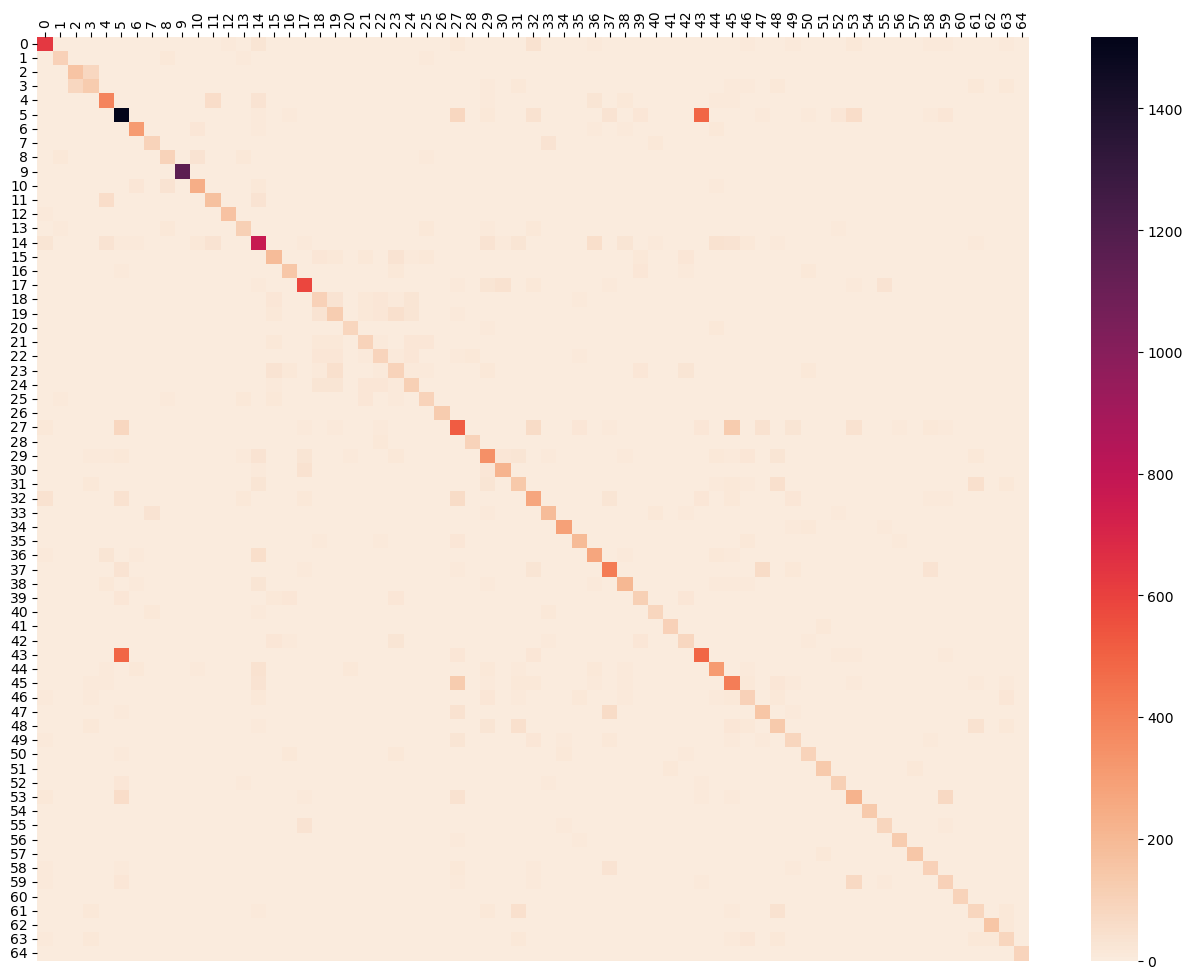

In [17]:
fig, ax = plt.subplots(figsize=(16, 12))

heatmap = sns.heatmap(func_mat_2, cmap = "rocket_r", ax=ax)

# Move the x-axis labels to the top
heatmap.set_xticklabels(heatmap.get_xticklabels(), rotation=90, ha='center')
ax.xaxis.tick_top()


plt.show()

In [18]:
# normalizing by zscore

func_mat_2_std = np.std(func_mat_2, axis = 0)
func_mat_2_std[func_mat_2_std == 0] = 10 ** -8 # avoiding deviding by zero

# calculate the z-score 
zscore = (func_mat_2 - np.mean(func_mat_2, axis = 0)) / func_mat_2_std

#np.ndarray.tolist(zscore_normalized_func_mat_2)

zscore

array([[ 7.97523028, -0.09955609, -0.1735265 , ..., -0.1440212 ,
         0.22908201, -0.13304673],
       [-0.14750637,  7.88951289, -0.1735265 , ..., -0.1440212 ,
        -0.30589993, -0.13304673],
       [-0.1603588 , -0.17944678,  7.16255334, ..., -0.1440212 ,
        -0.30589993, -0.13304673],
       ...,
       [-0.1603588 , -0.17944678, -0.1735265 , ...,  7.94801723,
         1.20988223, -0.13304673],
       [-0.08324421, -0.17944678, -0.1735265 , ...,  0.75509418,
         7.27301089, -0.13304673],
       [-0.1603588 , -0.17944678, -0.1735265 , ..., -0.1440212 ,
        -0.30589993,  7.99086729]])

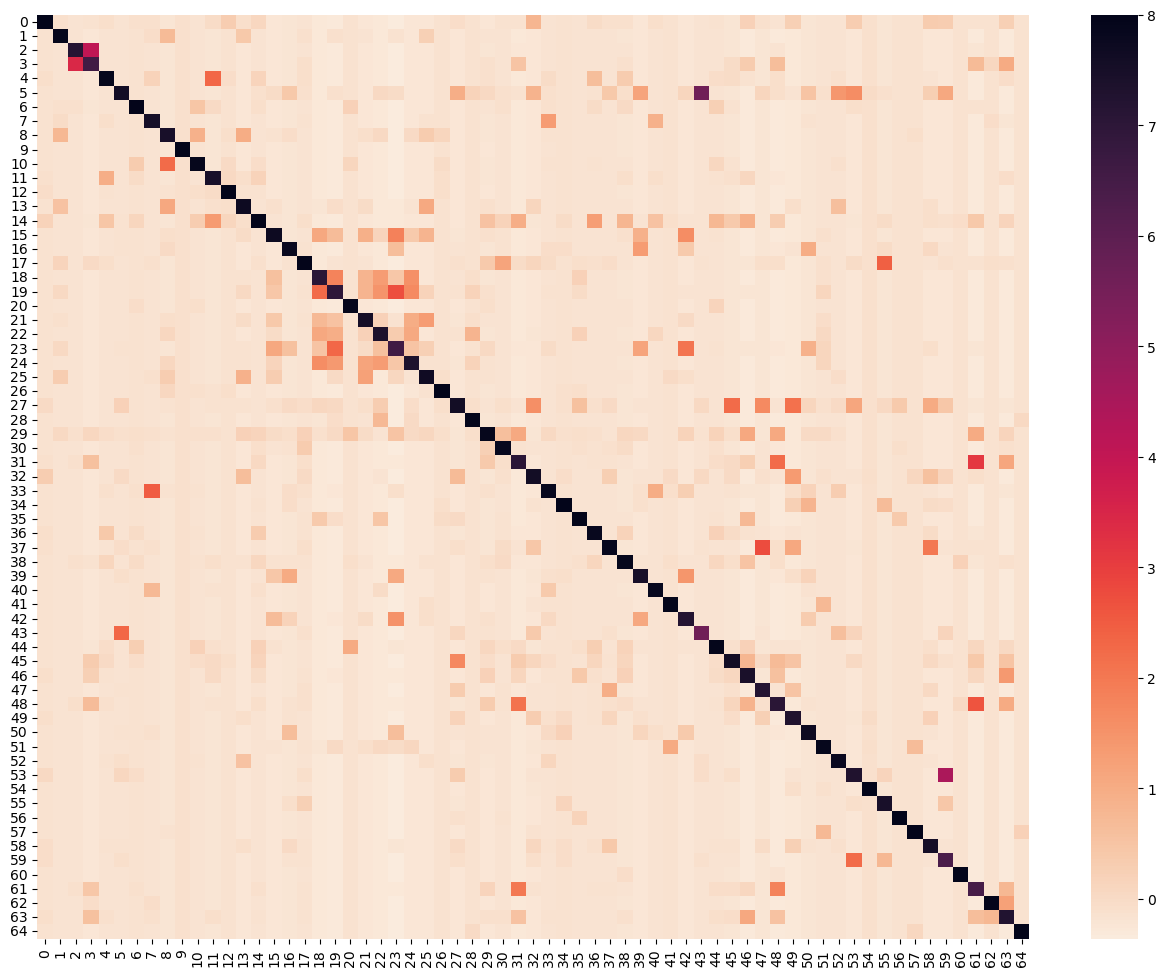

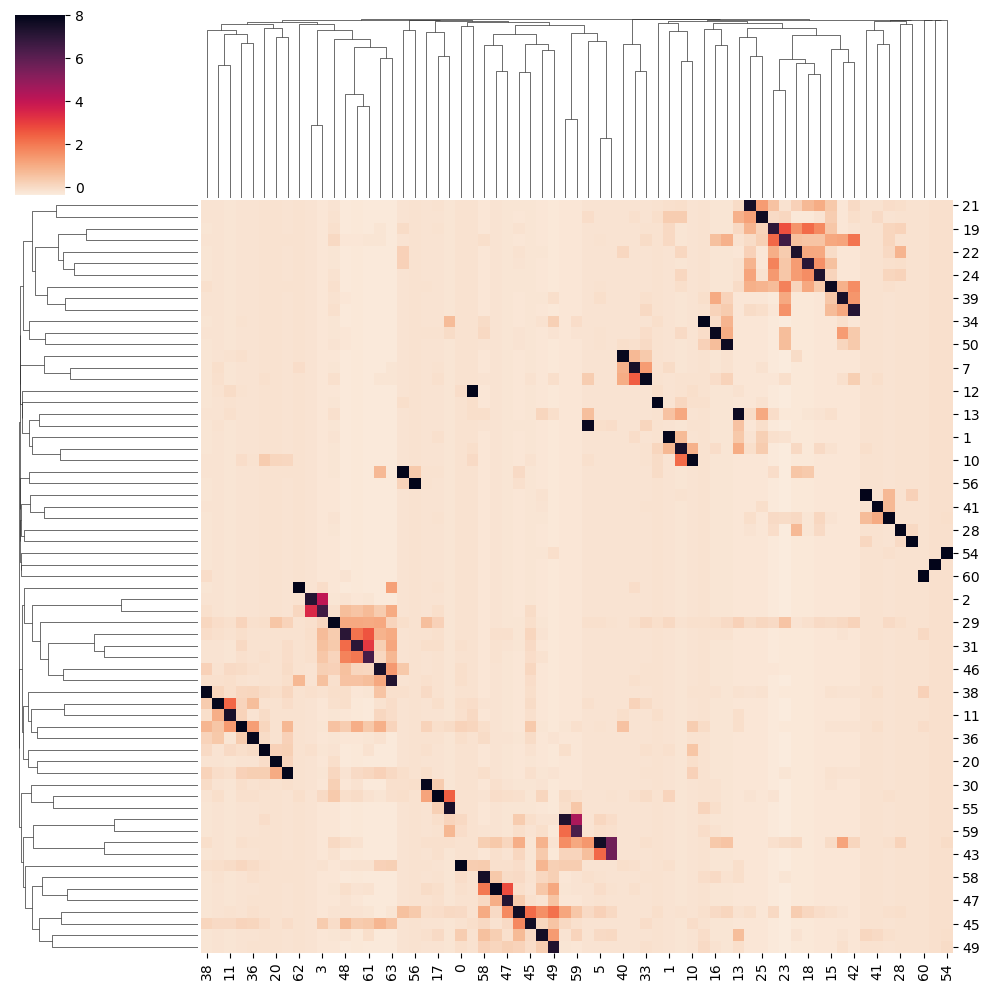

In [19]:
fig, ax = plt.subplots(figsize=(16, 12))

heatmap = sns.heatmap(zscore, cmap = "rocket_r", ax=ax)

sns.clustermap(zscore, cmap = "rocket_r")


plt.show()

In [20]:
# doing the same normalization, but with zeros diagonal

func_mat_diag_0 = func_mat_2.copy()

for i in range(len(func_mat_diag_0)):
    func_mat_diag_0[i,i] = 0

# normalizing by zscore

func_mat_diag_0_std = np.std(func_mat_diag_0, axis = 0)
func_mat_diag_0_std[func_mat_diag_0_std == 0] = 10 ** -8 # avoiding deviding by zero

# calculate the z-score 
zscore_2 = (func_mat_diag_0 - np.mean(func_mat_diag_0, axis = 0)) / func_mat_diag_0_std

#np.ndarray.tolist(zscore_normalized_func_mat_2)

zscore_2


array([[-0.44690903,  0.14829061, -0.13617315, ..., -0.17154239,
         0.82858881, -0.16876319],
       [-0.28371191, -0.33365387, -0.13617315, ..., -0.17154239,
        -0.45375102, -0.16876319],
       [-0.44690903, -0.33365387, -0.13617315, ..., -0.17154239,
        -0.45375102, -0.16876319],
       ...,
       [-0.44690903, -0.33365387, -0.13617315, ..., -0.17154239,
         3.17954516, -0.16876319],
       [ 0.53227367, -0.33365387, -0.13617315, ...,  7.72655503,
        -0.45375102, -0.16876319],
       [-0.44690903, -0.33365387, -0.13617315, ..., -0.17154239,
        -0.45375102, -0.16876319]])

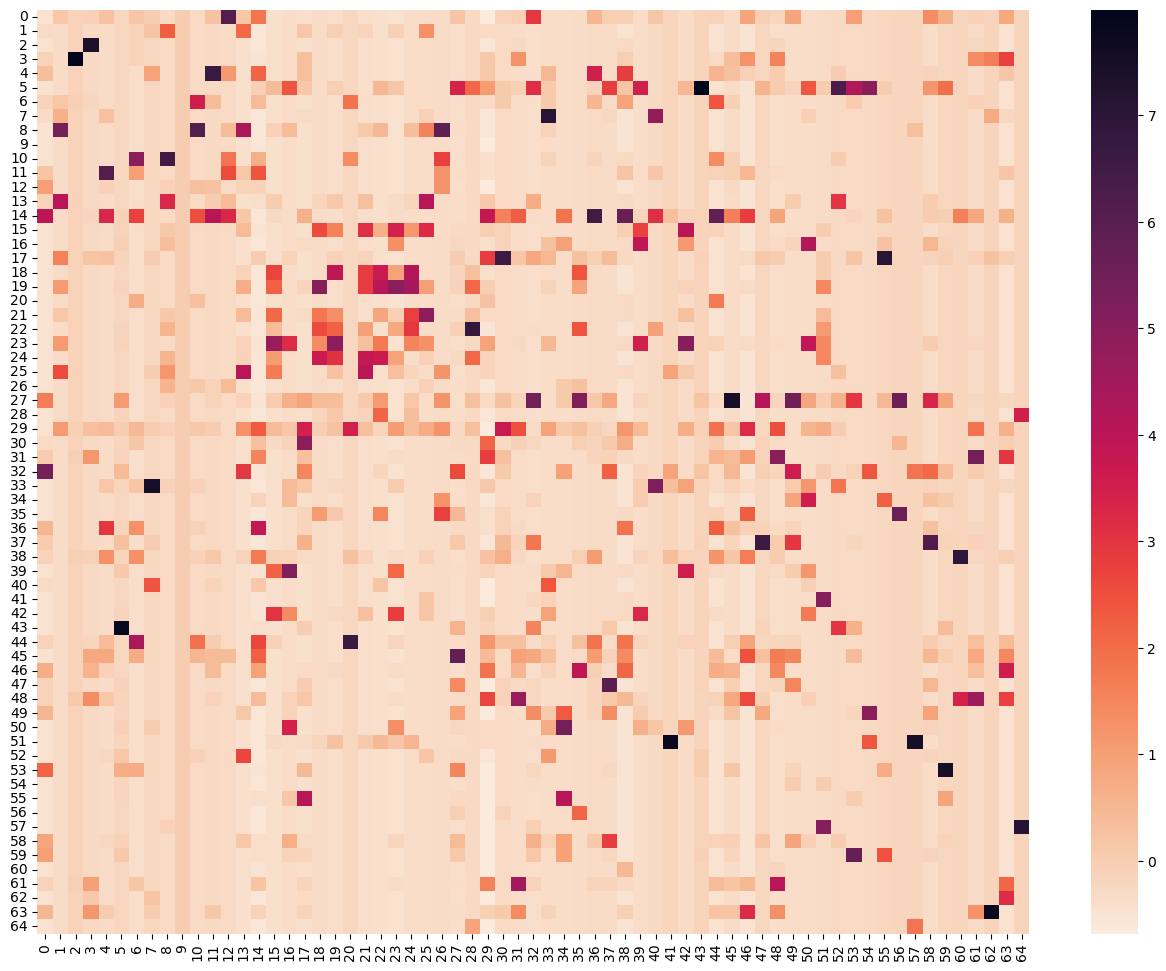

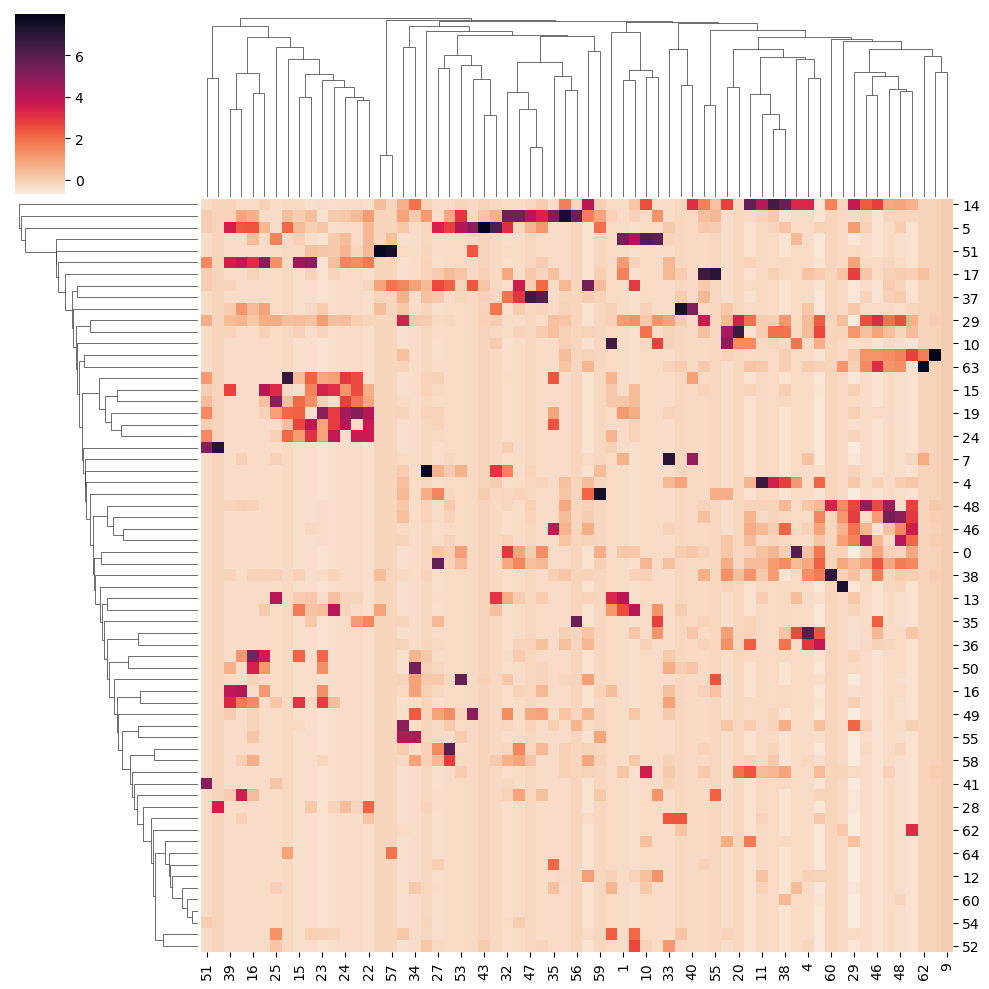

In [21]:
fig, ax = plt.subplots(figsize=(16, 12))

heatmap = sns.heatmap(zscore_2, cmap = "rocket_r", ax=ax)
sns.clustermap(zscore_2, cmap = "rocket_r")

plt.show()

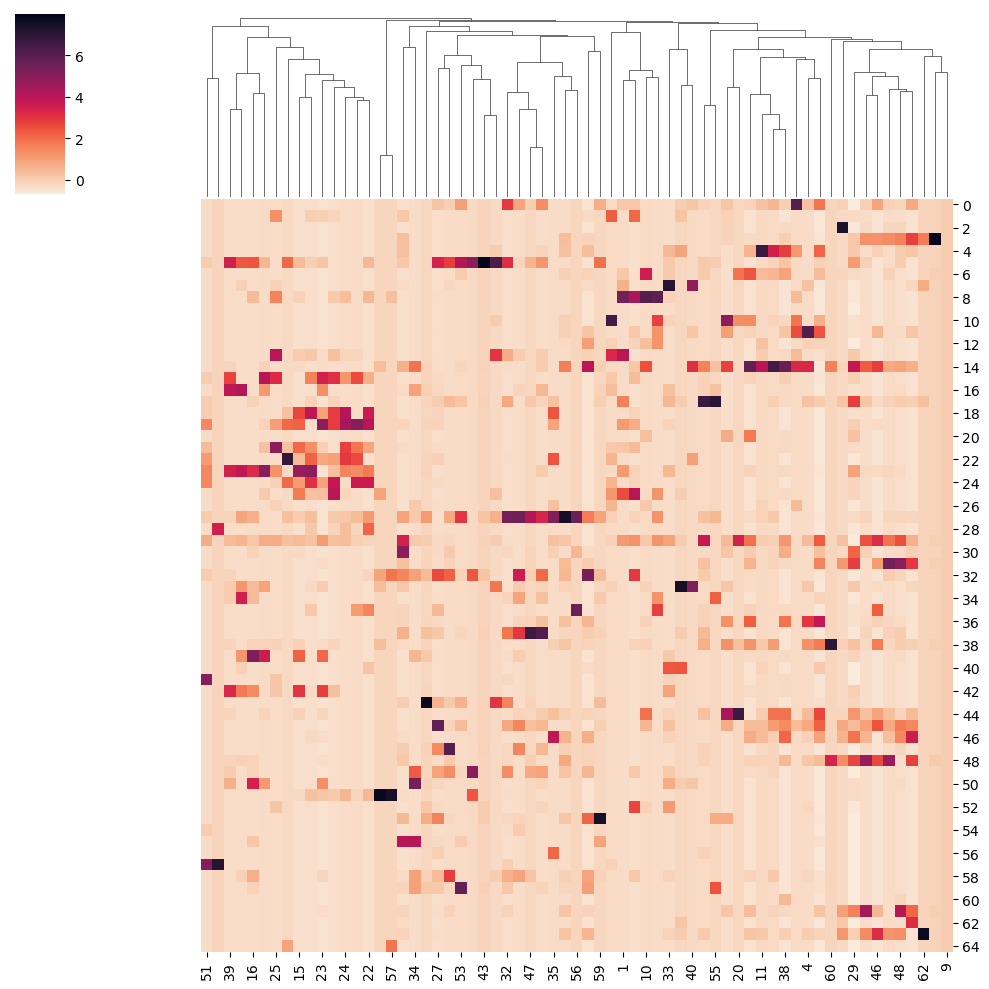

In [22]:
sns.clustermap(zscore_2, row_cluster = False, cmap = "rocket_r")

plt.show()

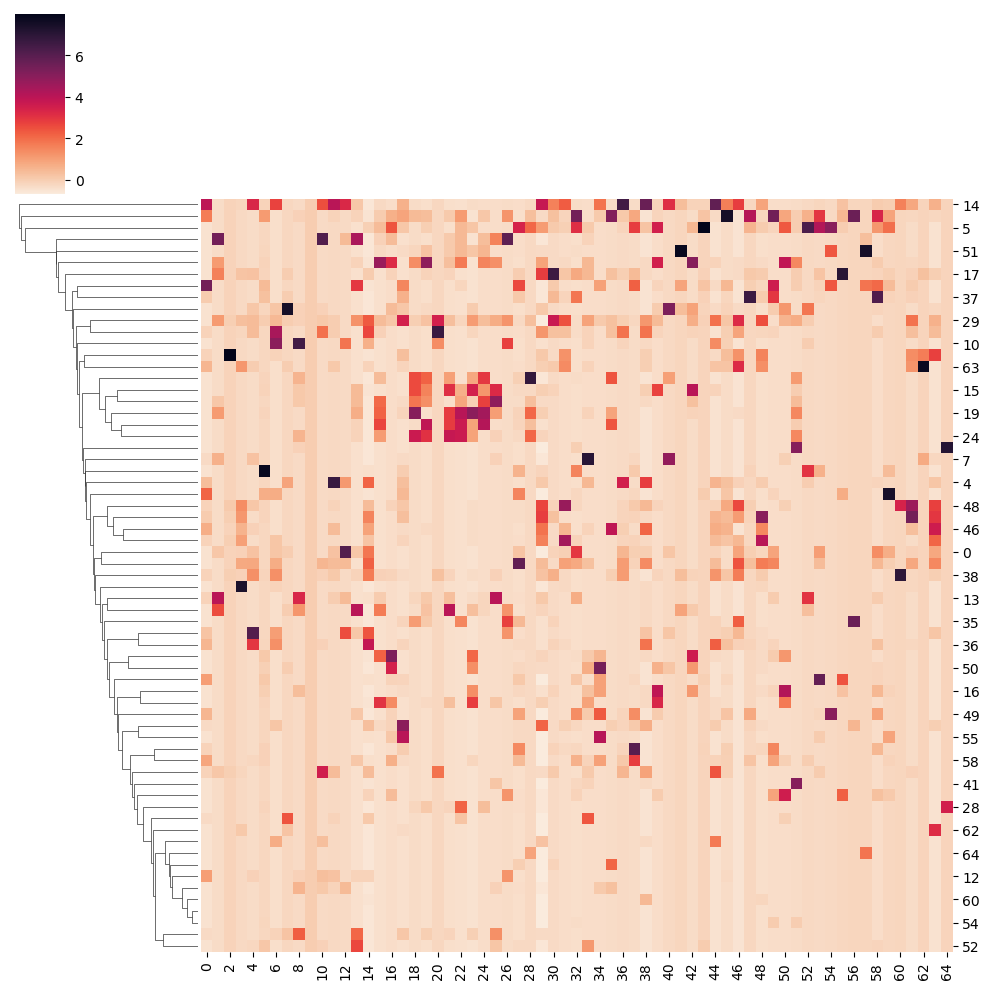

In [23]:
sns.clustermap(zscore_2, col_cluster = False, cmap = "rocket_r")

plt.show()

In [24]:
# conclusion - maybe should leave the diagonal zero? and clusters doesn't seem to appear in clustering only rows nor columns

Looking for exceptional KO's regarding multi_label length

In [25]:
unique_df['multi_label_clean'].str.len().agg(['mean', 'min', 'max', 'median'])

mean       1.560178
min        1.000000
max       23.000000
median     1.000000
Name: multi_label_clean, dtype: float64

/tmp/ipykernel_1543/977144050.py:5: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(unique_df['multi_label_size'], color = "purple")


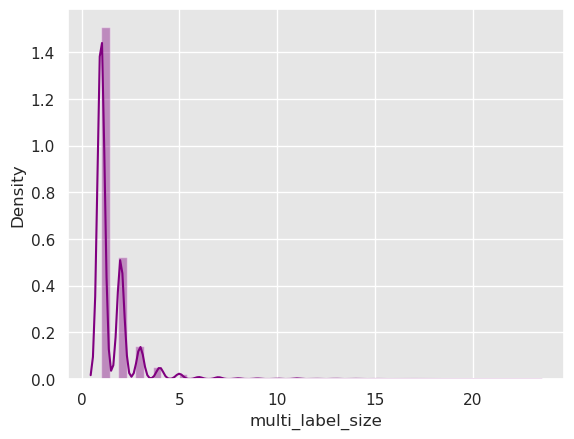

In [26]:
sns.set(style='ticks', palette='Set2')
sns.set_style("darkgrid", {"axes.facecolor": "0.9"})

unique_df['multi_label_size'] = unique_df['multi_label_clean'].map(len)
sns.distplot(unique_df['multi_label_size'], color = "purple")

plt.show()

In [27]:
# top 5 multi_label lists in length (all over 17 labels)
unique_df['exceptionaly_many_labels'] = unique_df['multi_label_clean'].apply(lambda x: len(x) > 17)
unique_df['exceptionaly_many_labels'].values.sum() 
unique_df[unique_df['exceptionaly_many_labels'] == True]["multi_label_clean"]

13690     [Human immunodeficiency virus 1 infection, EGF...
14484     [Human immunodeficiency virus 1 infection, EGF...
39310     [Human immunodeficiency virus 1 infection, EGF...
108223    [Hepatitis C, Epithelial cell signaling in Hel...
201806    [Hepatitis C, Epithelial cell signaling in Hel...
Name: multi_label_clean, dtype: object

In [28]:
# the KO's of these top 5
unique_df[unique_df['exceptionaly_many_labels'] == True]["KO"]

13690     K00922
14484     K04371
39310     K04456
108223    K02580
201806    K04734
Name: KO, dtype: object

In [29]:
# the longest multi_label below, belongs to K04371
unique_df[unique_df['exceptionaly_many_labels'] == True]["multi_label_clean"][14484]

['Human immunodeficiency virus 1 infection',
 'EGFR tyrosine kinase inhibitor resistance',
 'Apoptosis',
 'Chromosome and associated proteins',
 'Influenza A',
 'Salmonella infection',
 'Hepatitis B',
 'Yersinia infection',
 'Platinum drug resistance',
 'Shigellosis',
 'Human T-cell leukemia virus 1 infection',
 'Tuberculosis',
 'Protein kinases',
 'Kaposi sarcoma-associated herpesvirus infection',
 'Hepatitis C',
 'Coronavirus disease - COVID-19',
 'Exosome',
 'Endocrine resistance',
 'Human cytomegalovirus infection',
 'Human papillomavirus infection',
 'Regulation of actin cytoskeleton',
 'Pathogenic Escherichia coli infection',
 'Pertussis']

Additional functions

In [30]:
relevant_functions_dict = create_func_mat(relevant_functions)[1]

In [31]:
''' most_frequent_label function gets a label as input and returns the label it comes with the most 
in the same multi_label) '''
def most_frequent_label(label):
    loc = relevant_functions_dict[label]
    res_loc = numpy.argmax(func_mat[loc])
    return relevant_functions[res_loc]

In [32]:
''' labels_frequency_dict function gets a label as input and returns a dictionary with labels as keys
and number of timesthe labels come with the input label as value (comes with = in the same multi_label together) '''
def labels_frequency_dict(label):
    loc = relevant_functions_dict[label]
    values = func_mat[loc]
    n = len(relevant_functions)
    res = {relevant_functions[i]: values[i] for i in range(n) if i != loc}
    return res

In [33]:
''' labels_list_by_frequency function gets a label as input and returns a sorted list of labels from the labels
that comes with it most frequently to least (from all labels that do come with the input label at least once)
as tuple: label, num of appearances '''
def labels_list_by_frequency(label):
    label_freq_dict = labels_frequency_dict(label)
    relev_label_freq_dict = {key:val for key,val in label_freq_dict.items() if val != 0}
    res = sorted(relev_label_freq_dict.items(), key=lambda item: item[1], reverse = True)
    return res

In [34]:
# example on Transporters
labels_list_by_frequency('Transporters')

[('ABC transporters', 487.0),
 ('Two-component system', 79.0),
 ('Antimicrobial resistance genes', 55.0),
 ('Quorum sensing', 38.0),
 ('Secretion system', 30.0),
 ('Sulfur metabolism', 22.0),
 ('beta-Lactam resistance', 21.0),
 ('Fructose and mannose metabolism', 20.0),
 ('Exosome', 13.0),
 ('Galactose metabolism', 12.0),
 ('Amino sugar and nucleotide sugar metabolism', 11.0),
 ('Bacterial toxins', 10.0),
 ('Starch and sucrose metabolism', 9.0),
 ('Pertussis', 9.0),
 ('Nitrogen metabolism', 8.0),
 ('Antifolate resistance', 7.0),
 ('Bacterial motility proteins', 7.0),
 ('Biofilm formation - Vibrio cholerae', 7.0),
 ('Chromosome and associated proteins', 6.0),
 ('Bacterial chemotaxis', 6.0),
 ('Methane metabolism', 5.0),
 ('Glycolysis / Gluconeogenesis', 5.0),
 ('Selenocompound metabolism', 5.0),
 ('Flagellar assembly', 5.0),
 ('Platinum drug resistance', 5.0),
 ('Peptidases and inhibitors', 4.0),
 ('Butanoate metabolism', 4.0),
 ('Benzoate degradation', 4.0),
 ('Bacterial secretion syst

In [35]:
# another example on Secretion system
labels_list_by_frequency('Secretion system')

[('Bacterial secretion system', 74.0),
 ('Bacterial motility proteins', 60.0),
 ('Transporters', 30.0),
 ('Biofilm formation - Vibrio cholerae', 30.0),
 ('Protein export', 29.0),
 ('Epithelial cell signaling in Helicobacter pylori infection', 27.0),
 ('Quorum sensing', 24.0),
 ('Biofilm formation - Pseudomonas aeruginosa', 16.0),
 ('Two-component system', 11.0),
 ('Flagellar assembly', 11.0),
 ('Vibrio cholerae infection', 9.0),
 ('Pertussis', 8.0),
 ('Peptidases and inhibitors', 7.0),
 ('Chaperones and folding catalysts', 4.0),
 ('ABC transporters', 4.0),
 ('Shigellosis', 4.0),
 ('Biofilm formation - Escherichia coli', 4.0),
 ('Transcription factors', 3.0),
 ('Bacterial toxins', 3.0),
 ('Plant-pathogen interaction', 3.0),
 ('Salmonella infection', 2.0),
 ('Protein kinases', 2.0),
 ('Pathogenic Escherichia coli infection', 2.0),
 ('Pyrimidine metabolism', 1.0),
 ('Exosome', 1.0),
 ('Cell cycle - Caulobacter', 1.0),
 ('Bacterial chemotaxis', 1.0),
 ('Yersinia infection', 1.0),
 ('Antimi

common and general measures:
we will say a label is more "common" if it appears in more KO's.
we will say a label is more "general" if it appears with more\ many different labels on average.

In [36]:
most_common_count = max(functions_dict.values())

In [37]:
def common_count(label):
    return functions_dict[label]

In [38]:
def common_score(label):
    count = common_count(label)
    score = count / most_common_count
    return score

In [39]:
# example
common_score("Transcription factors")

0.41699604743083

/tmp/ipykernel_1543/3641641333.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_common_counts, color = "purple")


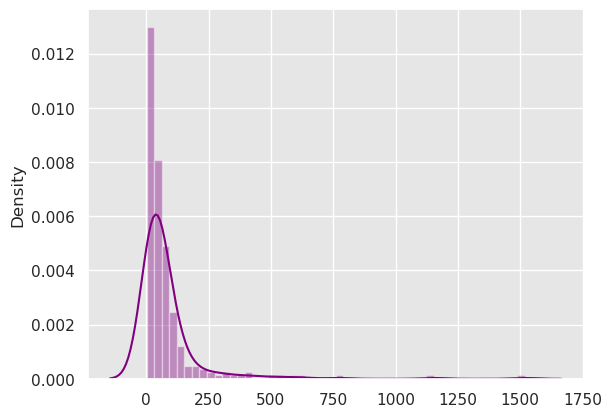

In [40]:
all_common_counts = list(functions_dict.values())
sns.distplot(all_common_counts, color = "purple")

plt.show()

In [41]:
most_general_count = max(np.count_nonzero(func_mat, axis = 1))
number_of_labels_without_self = len(func_mat) - 1

In [42]:
def generality_count(label):
    count = np.count_nonzero(func_mat[relevant_functions_dict[label]])
    return count

In [43]:
def generality_score(label):
    count = generality_count(label)
    score = count / number_of_labels_without_self
    return score

/tmp/ipykernel_1543/2954614930.py:2: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns.distplot(all_generality_counts, color = "purple")


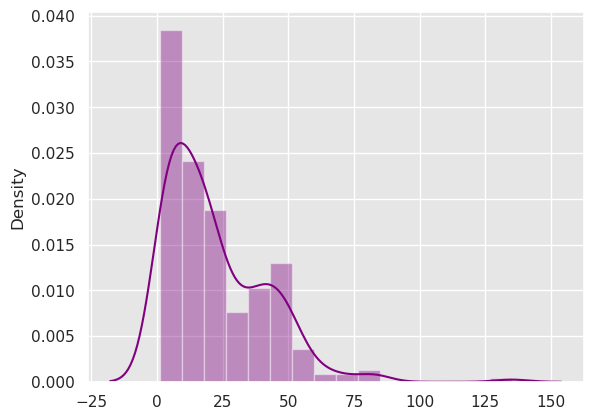

In [44]:
all_generality_counts = list(np.count_nonzero(func_mat, axis = 1))
sns.distplot(all_generality_counts, color = "purple")

plt.show()

In [45]:
# example
"generality score for Transporters - " + str(generality_score("Transporters")) + \
 " and generality score for ABC Transporters - " + str(generality_score("ABC transporters"))

'generality score for Transporters - 0.2556390977443609 and generality score for ABC Transporters - 0.08646616541353383'

In [46]:
Counter(functions_dict).most_common(5) # top 5 most common labels

[('Transporters', 1518),
 ('Enzymes with EC numbers', 1153),
 ('Chromosome and associated proteins', 773),
 ('Transcription factors', 633),
 ('Peptidases and inhibitors', 582)]

In [47]:
Counter(functions_dict).most_common(int(len(functions_dict) * 0.05)) # top 5% most common labels

[('Transporters', 1518),
 ('Enzymes with EC numbers', 1153),
 ('Chromosome and associated proteins', 773),
 ('Transcription factors', 633),
 ('Peptidases and inhibitors', 582),
 ('Two-component system', 517),
 ('ABC transporters', 488),
 ('Secretion system', 419),
 ('Protein kinases', 411),
 ('DNA repair and recombination proteins', 388),
 ('Exosome', 345),
 ('Ribosome biogenesis', 313),
 ('Messenger RNA biogenesis', 311)]

In [48]:
top_5_precent_generality_indices = sorted(range(len(all_generality_counts)), key=lambda i: all_generality_counts[i], reverse=True)[:int(len(all_generality_counts)*0.05)]

In [49]:
[(relevant_functions[idx], all_generality_counts[idx]) for idx in top_5_precent_generality_indices] # 5% most general labels

[('Exosome', 135),
 ('Chromosome and associated proteins', 83),
 ('Two-component system', 83),
 ('Peptidases and inhibitors', 82),
 ('Protein phosphatases and associated proteins', 73),
 ('Transporters', 68),
 ('Shigellosis', 66),
 ('Transcription factors', 62),
 ('Protein kinases', 59),
 ('Messenger RNA biogenesis', 58),
 ('Tryptophan metabolism', 56),
 ('Human T-cell leukemia virus 1 infection', 56),
 ('Salmonella infection', 54)]

In [50]:
all_relevant_common_counts = [functions_dict[relevant_functions[i]] for i in range(len(func_mat))]

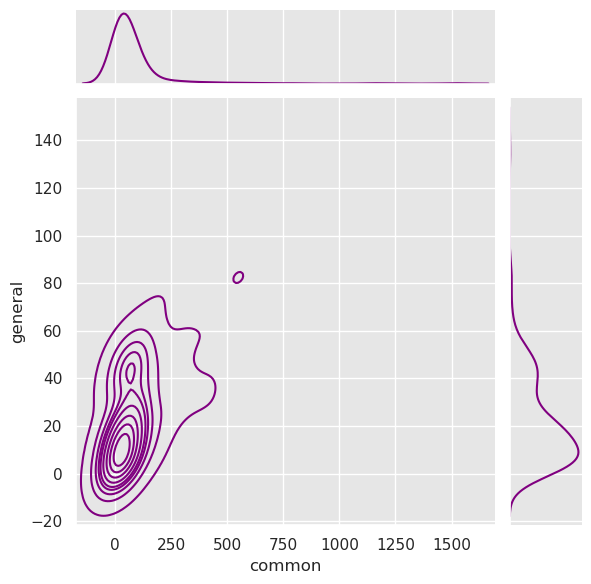

In [51]:
plt_data = pd.DataFrame({'general':all_generality_counts, 'common':all_relevant_common_counts})

sns.set_style("darkgrid", {"axes.facecolor": "0.9"})
sns.jointplot(x='common', y='general', data=plt_data, kind='kde', color = "purple")


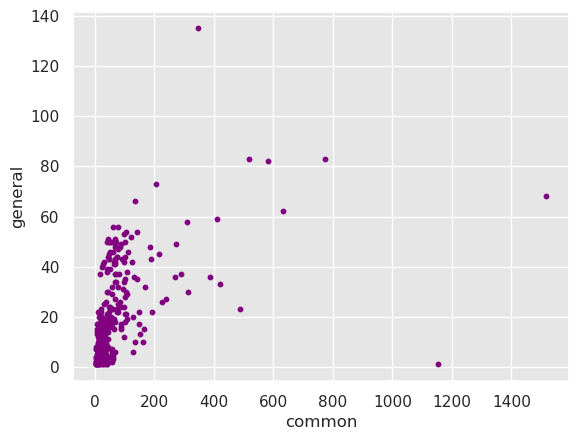

In [52]:
sns.set(style='ticks', palette='Set2')
sns.set_style("darkgrid", {"axes.facecolor": "0.9"})

plt.scatter(all_relevant_common_counts, all_generality_counts, color = "purple", s=10)

plt.xlabel("common")
plt.ylabel("general")

#plt.xlim(0,800)
plt.show()

In [53]:
corr_matrix = np.corrcoef(all_relevant_common_counts, all_generality_counts)
corr = corr_matrix[0,1]
R_sq = corr**2

R_sq

0.2083719262586748

In [54]:
# need to explore unusual points in scatter plot with the updated data 

Building a directed graph where nodes are labels, and there is an edge from f1 to f2 with weight = P(f2|f1)  

In [55]:
relevant_functions_avg_dict = create_func_mat(relevant_functions_avg)[1]

In [56]:
def edge_weight(f1, f2):
    f1_idx = relevant_functions_avg_dict[f1]
    f2_idx = relevant_functions_avg_dict[f2]
    
    P_f1 = functions_dict[f1] # symbols the probability to see f1 (the number of KOs f1 is i their multi label)
    P_f1_intersection_f2 = func_mat_2[f1_idx, f2_idx] # symbols the probability to see f1 with f2
    
    P_f2_given_f1 = P_f1_intersection_f2 / P_f1
    
    return P_f2_given_f1

In [57]:
labels_graph = nx.DiGraph()

for f in relevant_functions_avg:
    labels_graph.add_node(f)

In [58]:
for f1 in relevant_functions_avg:
    for f2 in relevant_functions_avg:
        if f1 != f2:
            e_weight = edge_weight(f1, f2)
            if e_weight > 0.2: # more than 20% of f1 appearances are with f2
                labels_graph.add_edge(f1, f2, weight= e_weight)

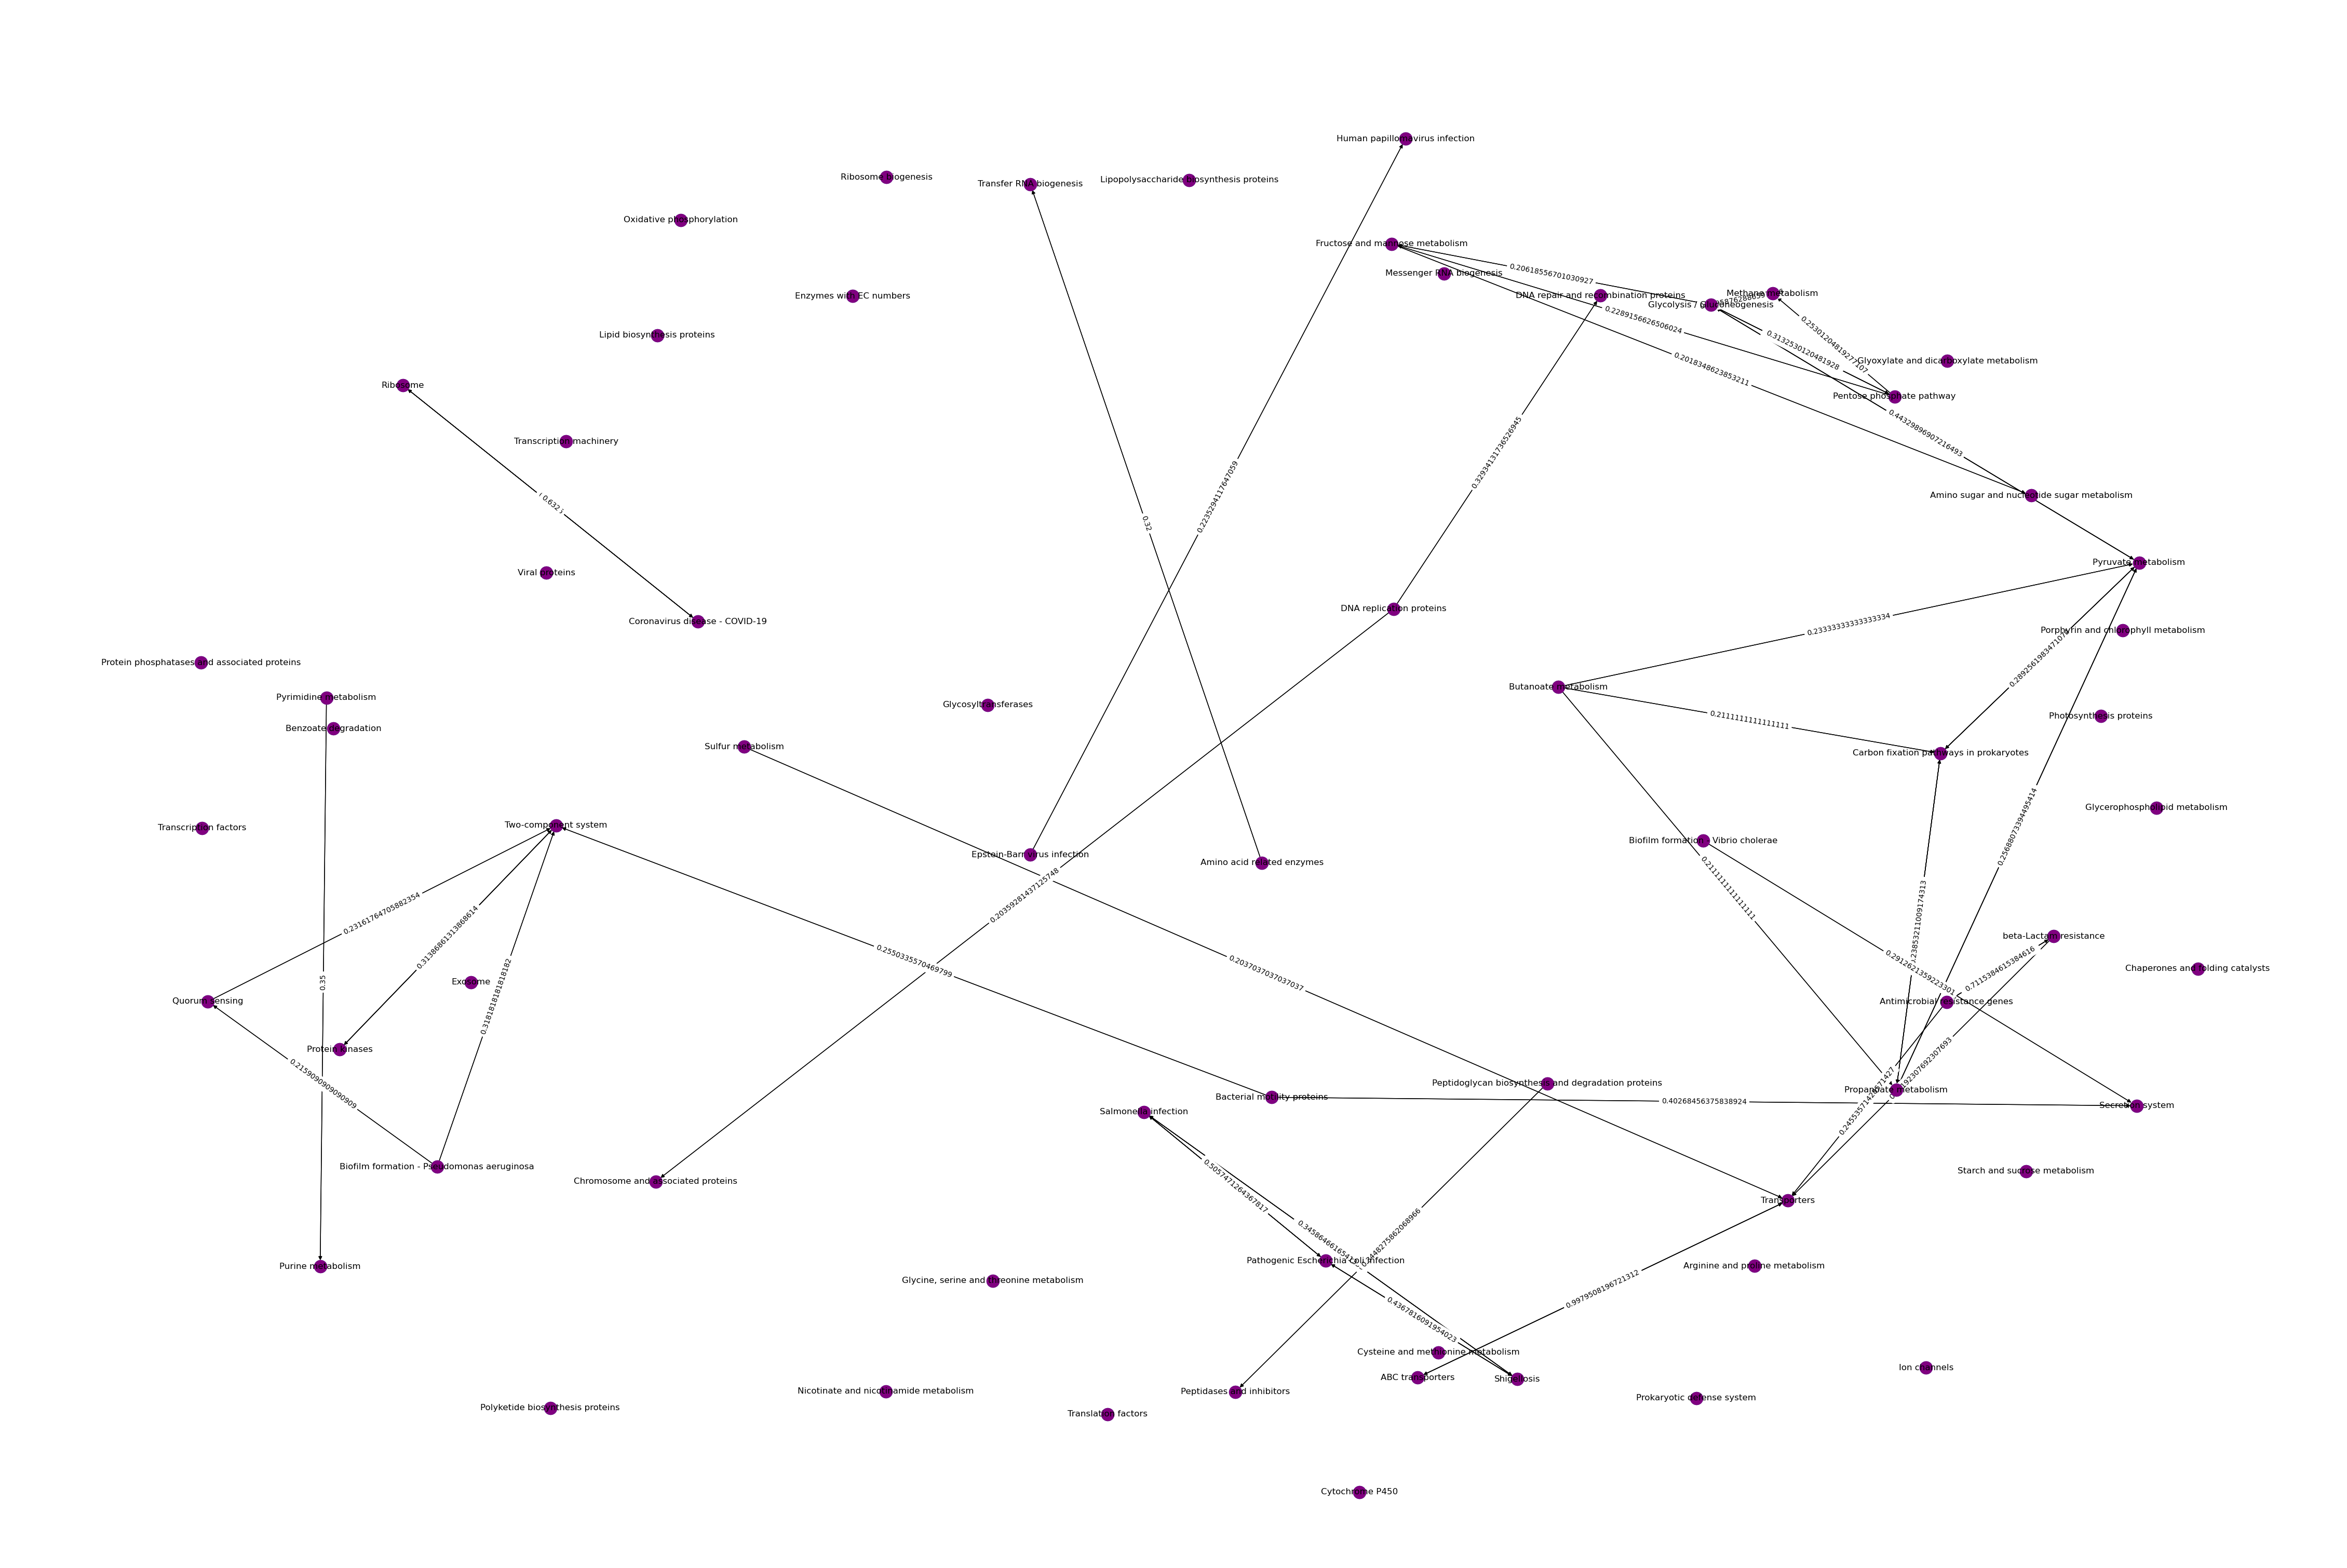

In [59]:
# plot
pos = nx.spring_layout(labels_graph, k=2*1/np.sqrt(len(labels_graph.nodes())), iterations=20)
plt.figure(3, figsize=(45, 30))
nx.draw(labels_graph, pos=pos)
nx.draw_networkx(labels_graph,pos, node_color = "purple")
labels = nx.get_edge_attributes(labels_graph,'weight')
nx.draw_networkx_edge_labels(labels_graph, pos=pos, edge_labels=labels)
plt.show()

In [60]:
# trying to visualize the graph using cytoscape

In [61]:
in_degree = dict(labels_graph.in_degree())
nx.set_node_attributes(labels_graph, in_degree, "in_degree")

cytoscape_data = nx.readwrite.json_graph.cytoscape_data(labels_graph)

In [62]:
import json

# exporting to a file called 'cytoscape_data.json'
with open('cytoscape_data.json', 'w') as outfile:
    json.dump(cytoscape_data, outfile)

In [63]:
# identifying strongly connected components

In [64]:
# Identify strongly connected components
strongly_connected_components = list(nx.strongly_connected_components(labels_graph))
label_to_component_dict = {}
# Print the strongly connected components
for i in range(len(strongly_connected_components)):
    print("Strongly Connected Component", str(i+1), ":", strongly_connected_components[i])
    for label in strongly_connected_components[i]:
        label_to_component_dict[label] = i+1

Strongly Connected Component 1 : {'Transcription factors'}
Strongly Connected Component 2 : {'Arginine and proline metabolism'}
Strongly Connected Component 3 : {'Ribosome', 'Coronavirus disease - COVID-19'}
Strongly Connected Component 4 : {'DNA repair and recombination proteins'}
Strongly Connected Component 5 : {'Transporters', 'ABC transporters'}
Strongly Connected Component 6 : {'Ribosome biogenesis'}
Strongly Connected Component 7 : {'Purine metabolism'}
Strongly Connected Component 8 : {'Pyrimidine metabolism'}
Strongly Connected Component 9 : {'Transfer RNA biogenesis'}
Strongly Connected Component 10 : {'Amino acid related enzymes'}
Strongly Connected Component 11 : {'Enzymes with EC numbers'}
Strongly Connected Component 12 : {'Chromosome and associated proteins'}
Strongly Connected Component 13 : {'DNA replication proteins'}
Strongly Connected Component 14 : {'Prokaryotic defense system'}
Strongly Connected Component 15 : {'Cysteine and methionine metabolism'}
Strongly Conne

In [65]:
from collections import Counter

KO_components_df = pd.DataFrame(columns=['KO','multi_components', 'single_component'])
for index, row in unique_df.iterrows():
    KO = row['KO']
    multi_label = row['multi_label_clean']
    labels_components_count = []
    for label in multi_label:
        if label in label_to_component_dict.keys():
            labels_components_count.append(label_to_component_dict[label])
            
    if len(labels_components_count) == 0: # KO doesn't belong to any component
        continue;

    # Use Counter to count the occurrences of each number
    components_counts = Counter(labels_components_count)

    # finding the most common component from the KO labels
    single_component = components_counts.most_common(1)[0][0]
    multi_components = sorted(set(labels_components_count))
    
    new_row = {'KO': KO,'multi_components': multi_components, 'single_component': single_component}
    KO_components_df = pd.concat([KO_components_df,pd.DataFrame([new_row])],ignore_index=True)
    
print(KO_components_df)

           KO multi_components single_component
0      K07728              [1]                1
1      K00286              [2]                2
2      K02868              [3]                3
3      K02987              [3]                3
4      K04484              [4]                4
...       ...              ...              ...
11355  K21339             [11]               11
11356  K09202              [1]                1
11357  K11567             [12]               12
11358  K15183         [34, 36]               34
11359  K15416             [50]               50

[11360 rows x 3 columns]


In [66]:
# fetching elaborate KO's and vectors

In [67]:
ko_2_word = '/davidb/daniellemiller/BioNLP/model_data.csv'

In [68]:
ko_2_word_df = pd.read_csv(ko_2_word)

ko_2_word_df = ko_2_word_df[['KO', 'word']]

ko_2_word_df

,KO,word
0,K07728,K07728.1
1,K00286,K00286.1
2,K00053,K00053.1
3,K02868,K02868.1
4,K02987,K02987.1
...,...,...
563584,NaN,hypo.clst.3316804
563585,NaN,hypo.clst.2540822
563586,NaN,hypo.clst.15921839
563587,NaN,hypo.clst.755733


In [95]:
merged_df = pd.merge(ko_2_word_df, KO_components_df, on='KO', how='outer')

merged_df = merged_df.dropna(subset=['single_component'], inplace=False)

merged_df

,KO,word,multi_components,single_component
0,K07728,K07728.1,[1],1
1,K07728,K07728.2,[1],1
2,K00286,K00286.1,[2],2
3,K00286,K00286.3,[2],2
4,K00286,K00286.4,[2],2
...,...,...,...,...
563581,K21339,K21339.1,[11],11
563582,K09202,K09202.1,[1],1
563584,K11567,K11567.3,[12],12
563587,K15183,K15183.4,"[34, 36]",34


In [71]:
from gensim.models import word2vec as w2v

model = w2v.Word2Vec.load('/davidb/daniellemiller/BioNLP/trained_models/final/batch_93804/annotation_extended/gene2vec_w5_v300_tf24_annotation_extended/gene2vec_w5_v300_tf24_annotation_extended_2021-10-03.w2v')

In [91]:
features = [model.wv[word] for word in merged_df['word']]
model_matrix_df_data = {'word': merged_df['word'], 'features': features}

model_matrix_df = pd.DataFrame(model_matrix_df_data)

In [96]:
model_matrix_df

,word,features
0,K07728.1,"[0.14434429, -0.5840874, -0.32904324, 0.378883..."
1,K07728.2,"[-0.41285217, 0.018408101, -0.088119246, 0.228..."
2,K00286.1,"[0.3042234, -0.32180947, -0.42920944, -0.05607..."
3,K00286.3,"[0.3816616, 0.12099825, -0.32753447, 0.0813822..."
4,K00286.4,"[0.14208522, 0.67150086, -0.16147946, -0.04562..."
...,...,...
563581,K21339.1,"[0.06447353, 0.1676698, -0.032590955, 0.050383..."
563582,K09202.1,"[0.0065535186, 0.0014128188, 0.06787821, 0.424..."
563584,K11567.3,"[0.096028216, 0.20593351, -0.053876847, 0.2162..."
563587,K15183.4,"[0.036188833, 0.10897209, -0.09915431, 0.28305..."


In [99]:
# Split the "features" column into 300 separate columns
for i in range(300):
    model_matrix_df = model_matrix_df.copy()
    model_matrix_df[f'feature_{i + 1}'] = model_matrix_df['features'].apply(lambda x: x[i])

# Drop the original "features" column
model_matrix_df.drop(columns=['features'], inplace=True)

model_matrix_df

,word,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_291,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300
0,K07728.1,0.144344,-0.584087,-0.329043,0.378883,0.294503,-0.226094,0.412635,0.399415,0.127360,...,-0.114233,0.110047,-0.297821,-0.039580,-0.189370,-0.281454,0.046189,-0.219050,-0.136706,-0.711540
1,K07728.2,-0.412852,0.018408,-0.088119,0.228479,-0.199707,0.010558,0.183430,0.054763,0.436126,...,0.161702,0.132452,-0.269281,0.415810,-0.250189,-0.155751,0.032070,-0.053134,-0.109881,-0.339071
2,K00286.1,0.304223,-0.321809,-0.429209,-0.056072,-0.464929,-0.003020,0.226863,0.162587,0.215890,...,-0.230473,0.587305,-0.424927,-0.169077,-0.161754,-0.175364,-0.079843,-0.375484,-0.078398,0.046153
3,K00286.3,0.381662,0.120998,-0.327534,0.081382,-0.097718,-0.120406,-0.149841,0.075000,0.030191,...,0.356792,-0.470854,0.017434,-0.363265,0.403733,0.099167,-0.034178,-0.006740,-0.247744,-0.106728
4,K00286.4,0.142085,0.671501,-0.161479,-0.045623,-0.951885,-0.283703,-0.340256,0.345086,0.051667,...,0.166538,-0.198300,-0.366637,0.347684,-0.331722,0.011777,-0.818572,0.518331,-0.290615,0.268024
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
563581,K21339.1,0.064474,0.167670,-0.032591,0.050384,0.020833,-0.314951,0.063372,-0.276641,0.082468,...,0.000181,-0.144878,-0.212779,0.201473,-0.333308,-0.084022,0.051087,0.113595,-0.000941,-0.115147
563582,K09202.1,0.006554,0.001413,0.067878,0.424821,-0.006112,0.067168,0.313961,-0.231944,-0.071989,...,0.079700,-0.220805,-0.239458,0.228604,-0.191360,-0.033228,0.306023,-0.131444,0.114713,0.010199
563584,K11567.3,0.096028,0.205934,-0.053877,0.216273,-0.046461,0.009749,0.355759,-0.013658,0.034214,...,0.081572,-0.074312,-0.026910,0.151773,-0.462582,0.099069,0.153609,-0.024829,0.243178,-0.058943
563587,K15183.4,0.036189,0.108972,-0.099154,0.283059,0.042879,-0.169438,0.190475,-0.210383,0.309542,...,-0.023855,-0.044258,-0.274391,0.118696,-0.318848,0.080273,0.106476,0.073779,-0.048750,-0.004613


In [100]:
model_matrix_with_components_df = pd.merge(model_matrix_df, merged_df, on='word', how='outer')

model_matrix_with_components_df.drop(columns=['KO', 'multi_components'], inplace=True)

In [101]:
model_matrix_with_components_df

,word,feature_1,feature_2,feature_3,feature_4,feature_5,feature_6,feature_7,feature_8,feature_9,...,feature_292,feature_293,feature_294,feature_295,feature_296,feature_297,feature_298,feature_299,feature_300,single_component
0,K07728.1,0.144344,-0.584087,-0.329043,0.378883,0.294503,-0.226094,0.412635,0.399415,0.127360,...,0.110047,-0.297821,-0.039580,-0.189370,-0.281454,0.046189,-0.219050,-0.136706,-0.711540,1
1,K07728.2,-0.412852,0.018408,-0.088119,0.228479,-0.199707,0.010558,0.183430,0.054763,0.436126,...,0.132452,-0.269281,0.415810,-0.250189,-0.155751,0.032070,-0.053134,-0.109881,-0.339071,1
2,K00286.1,0.304223,-0.321809,-0.429209,-0.056072,-0.464929,-0.003020,0.226863,0.162587,0.215890,...,0.587305,-0.424927,-0.169077,-0.161754,-0.175364,-0.079843,-0.375484,-0.078398,0.046153,2
3,K00286.3,0.381662,0.120998,-0.327534,0.081382,-0.097718,-0.120406,-0.149841,0.075000,0.030191,...,-0.470854,0.017434,-0.363265,0.403733,0.099167,-0.034178,-0.006740,-0.247744,-0.106728,2
4,K00286.4,0.142085,0.671501,-0.161479,-0.045623,-0.951885,-0.283703,-0.340256,0.345086,0.051667,...,-0.198300,-0.366637,0.347684,-0.331722,0.011777,-0.818572,0.518331,-0.290615,0.268024,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
31854,K21339.1,0.064474,0.167670,-0.032591,0.050384,0.020833,-0.314951,0.063372,-0.276641,0.082468,...,-0.144878,-0.212779,0.201473,-0.333308,-0.084022,0.051087,0.113595,-0.000941,-0.115147,11
31855,K09202.1,0.006554,0.001413,0.067878,0.424821,-0.006112,0.067168,0.313961,-0.231944,-0.071989,...,-0.220805,-0.239458,0.228604,-0.191360,-0.033228,0.306023,-0.131444,0.114713,0.010199,1
31856,K11567.3,0.096028,0.205934,-0.053877,0.216273,-0.046461,0.009749,0.355759,-0.013658,0.034214,...,-0.074312,-0.026910,0.151773,-0.462582,0.099069,0.153609,-0.024829,0.243178,-0.058943,12
31857,K15183.4,0.036189,0.108972,-0.099154,0.283059,0.042879,-0.169438,0.190475,-0.210383,0.309542,...,-0.044258,-0.274391,0.118696,-0.318848,0.080273,0.106476,0.073779,-0.048750,-0.004613,34


In [67]:
# graph table

In [68]:
in_deg02 = dict(labels_graph.in_degree())
out_deg02 = dict(labels_graph.out_degree())

in_weight02 = dict(labels_graph.in_degree(weight = 'weight'))
out_weight02 = dict(labels_graph.out_degree(weight = 'weight'))

#The degree is the sum of the edge weights adjacent to the node

funcs02 = list(out_deg02.keys())

avg_out_weight02 = [out_weight02[func] / out_deg02[func] if out_deg02[func] != 0 else 0 for func in funcs02]
avg_in_weight02 = [in_weight02[func] / in_deg02[func]  if in_deg02[func] != 0 else 0 for func in funcs02]

in_degree_centrality02 = nx.in_degree_centrality(labels_graph)
out_degree_centrality02 = nx.out_degree_centrality(labels_graph)

# The degree centrality for a node v is the fraction of nodes it is connected to.

# centrality02 = nx.eigenvector_centrality(labels_graph)
# eigen_centrality02 = dict([(k, f"{v:0.5f}") for k, v in centrality.items()])

#Eigenvector centrality computes the centrality for a node based on the centrality of its neighbors.
#The eigenvector centrality for node i is the i-th element of the vector x defined by the equation Ax = cx

In [64]:
graph_data02 = {'Label': funcs02, 'in degree': list(in_deg02.values()), 'out_degree': list(out_deg02.values()),
                    'in deg computed with weight': list(in_weight02.values()), 'out deg computed with weight': list(out_weight02.values()),
                     'average_in_weight': avg_in_weight02, 'average_out_weight': avg_out_weight02,
                     'in deg centrality' : in_degree_centrality02.values(), 'out deg centrality' : out_degree_centrality02.values()}

In [65]:
graph_df02 = pd.DataFrame(graph_data02)
graph_df02.sort_values(by=["in deg centrality"], ascending=False)

,Label,in degree,out_degree,in deg computed with weight,out deg computed with weight,average_in_weight,average_out_weight,in deg centrality,out deg centrality
18,Pyruvate metabolism,4,3,1.276650,0.876033,0.319163,0.292011,0.062500,0.046875
5,Transporters,4,1,1.649113,0.320817,0.412278,0.320817,0.062500,0.015625
27,Two-component system,4,1,1.118702,0.249516,0.279675,0.249516,0.062500,0.015625
19,Carbon fixation pathways in prokaryotes,3,2,0.738899,0.598039,0.246300,0.299020,0.046875,0.031250
24,Propanoate metabolism,3,2,0.697418,0.495413,0.232473,0.247706,0.046875,0.031250
...,...,...,...,...,...,...,...,...,...
34,Glycosyltransferases,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
35,Oxidative phosphorylation,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
36,Transcription machinery,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
38,Protein phosphatases and associated proteins,0,0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000


In [66]:
# all_labels_graph_ud contains all nodes and edges that weigh more than 0 (above avg). this is an undirected graph.

In [67]:
all_labels_graph_ud = nx.Graph()

In [68]:
for f in relevant_functions_avg:
    all_labels_graph_ud.add_node(f)

In [69]:
for f1 in relevant_functions_avg:
    for f2 in relevant_functions_avg:
        if f1 != f2:
            e_weight_1 = edge_weight(f1, f2)
            e_weight_2 = edge_weight(f2, f1)
            weights_avg = (e_weight_1 + e_weight_2) / 2
            if weights_avg > 0:
                all_labels_graph_ud.add_edge(f1, f2, weight= weights_avg)

In [70]:
# performing louvain community detection

Compute the partition of the graph nodes which maximises the modularity (or try..) using the Louvain heuristices

This is the partition of highest modularity, i.e. the highest partition of the dendrogram generated by the Louvain algorithm.

modularity formula: 

Q = 1/2m * sum_i_j{(Aij - kikj/2m)*delta(ci, cj)}

where:

Aij represents the edge weight between nodes i and j;
ki and kj are the sum of the weights of the edges attached to nodes i and j, respectively;
m is the sum of all of the edge weights in the graph;
ci and cj are the communities of the nodes; 
delta is Kronecker delta function (delta(x,y) = 1 if x=y, 0 otherwise)

In [71]:
# Import libraries
from networkx.algorithms import community
import community as community_louvain
import igraph as ig
import matplotlib.cm as cm

In [72]:
from collections import defaultdict

In [73]:
partition_res_05 = community_louvain.best_partition(all_labels_graph_ud, resolution = 0.5)

In [74]:
def print_partition(partition):
    grouped = defaultdict(set)

    for k, v in partition.items():
        grouped[v].add(k)

    result = list(grouped.values())

    for community in result:
        print('\n')
        print(community)

In [75]:
print_partition(partition_res_05)



{'Transcription factors', 'Glycosyltransferases', 'Peptidases and inhibitors', 'Peptidoglycan biosynthesis and degradation proteins', 'Chaperones and folding catalysts', 'beta-Lactam resistance', 'Antimicrobial resistance genes'}


{'Amino acid related enzymes', 'Glycine, serine and threonine metabolism', 'Arginine and proline metabolism', 'Porphyrin and chlorophyll metabolism', 'Cysteine and methionine metabolism', 'Transfer RNA biogenesis'}


{'Coronavirus disease - COVID-19', 'Ribosome'}


{'Ion channels', 'DNA repair and recombination proteins', 'Translation factors', 'Transcription machinery', 'Chromosome and associated proteins', 'Ribosome biogenesis', 'DNA replication proteins', 'Protein phosphatases and associated proteins', 'Messenger RNA biogenesis', 'Prokaryotic defense system'}


{'Sulfur metabolism', 'Transporters', 'ABC transporters'}


{'Purine metabolism', 'Pyrimidine metabolism', 'Nicotinate and nicotinamide metabolism'}


{'Enzymes with EC numbers'}


{'Glycolysis /